In [1]:
import os
import sys
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import folium
%matplotlib inline
from pykrige.ok import OrdinaryKriging
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import pykrige.kriging_tools as kt
import seaborn as sb
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

## Import the data

Well known spatial dataset: http://spatial-analyst.net/book/meusegrids

In [2]:
meuse = gpd.read_file('meuse/meuse.shp')
meuse.crs = {'init':'epsg:28992'}
meuse['x'] = meuse['geometry'].apply(lambda x: x.x)
meuse['y'] = meuse['geometry'].apply(lambda x: x.y)
meuse.sample()

,cadmium,copper,dist,dist.m,elev,ffreq,geometry,landuse,lead,lime,om,soil,zinc,x,y
31,1.3,21.0,0.287957,390.0,8.727,1,POINT (180878 332489),Ag,64.0,0,1.0,2,198.0,180878.0,332489.0


## Spatial plot

In [3]:
feature_to_plot = 'lead'

meuse_lat_long = meuse.to_crs({'init': 'epsg:4326'})
meuse_lat_long['long'] = meuse_lat_long.geometry.apply(lambda x: x.x)
meuse_lat_long['lat'] = meuse_lat_long.geometry.apply(lambda x: x.y)
mean_long = np.mean(meuse_lat_long['long'])
mean_lat = np.mean(meuse_lat_long['lat'])
m = folium.Map([mean_lat, mean_long], zoom_start=13, tiles='Stamen Toner')
scale = folium.colormap.linear.YlOrRd.scale(vmin = 0, vmax=meuse_lat_long[feature_to_plot].max())
for row in meuse_lat_long.iterrows():
    folium.CircleMarker(location=[row[1]['lat'], row[1]['long']], radius=50,color=None,fill_opacity = 1,
                    fill_color=scale(row[1][feature_to_plot])).add_to(m)
m.add_children(scale)

## Split the data into test and train

In [4]:
test_indexes = np.random.choice(a = meuse.index, size = int(np.round(len(meuse.index.values)/4)))
train_indexes = [index for index in meuse.index if index not in test_indexes]
meuse_test = meuse.loc[test_indexes,:].copy()
meuse_train = meuse.loc[train_indexes,:].copy()
print('Number of observations in training: {}, in test: {}'.format(len(meuse_train), len(meuse_test)))

Number of observations in training: 120, in test: 39


## Ordinary kriging

Variogram parameters are set with trail and error

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'spherical' Variogram Model
Sill: 15000
Range: 900
Nugget: 4000 



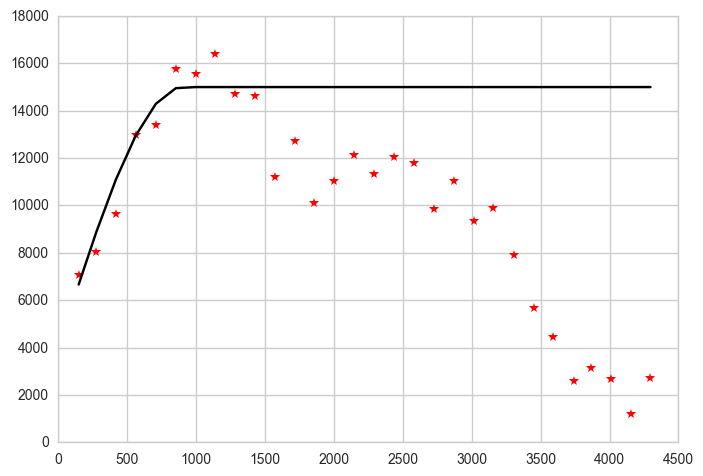

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Executing Ordinary Kriging...



In [26]:
model = OrdinaryKriging(x = meuse_train['x'], y = meuse_train['y'], z = meuse_train['lead'], verbose = True,
                variogram_parameters= [15000, 900, 4000],
                enable_plotting = True, nlags=30, weight=True, variogram_model = 'spherical')
meuse_train['prediction'] = model.execute(style = 'points',xpoints = meuse_train['x'], ypoints = meuse_train['y'] )[0].data
meuse_train['kriging_residual'] = meuse_train['lead'] - meuse_train['prediction']
meuse_test['prediction'] = model.execute(style = 'points',xpoints = meuse_test['x'], ypoints = meuse_test['y'] )[0].data
meuse_test['kriging_residual'] = meuse_test['lead'] - meuse_test['prediction']

## Model performance

- Performance on training data (kriging is an exact interpollator, so perfect prediction)
- Performance on test data

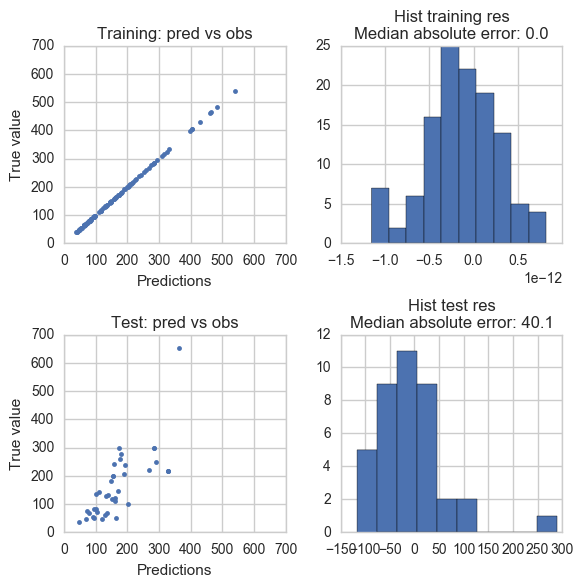

In [27]:
plt.figure(figsize=(6,6))
plt.subplot(221)
plt.plot(meuse_train['prediction'], meuse_train['lead'], '.')
plt.title('Training: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.ylim(0,700)
plt.xlim(0,700)
plt.subplot(222)
meuse_train['kriging_residual'].hist()
plt.title('Hist training res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(meuse_train['kriging_residual']))))
plt.subplot(223)
plt.plot(meuse_test['prediction'], meuse_test['lead'], '.')
plt.title('Test: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.ylim(0,700)
plt.xlim(0,700)
plt.subplot(224)
meuse_test['kriging_residual'].hist()
plt.title('Hist test res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(meuse_test['kriging_residual']))))
plt.tight_layout()

## Benchmark with Nearest Neighbours regression

Optimise number of neighbours with sklearn gridsearch

In [28]:
parameters = {'n_neighbors':np.arange(1,10)}
nn_model = KNeighborsRegressor()
nn_model_cv = GridSearchCV(nn_model, parameters)
nn_model_cv = nn_model_cv.fit(meuse_train[['x', 'y']], meuse_train['lead']) 
print('Optimal number of neighbours {}'.format(nn_model_cv.best_params_))
nn_model = nn_model_cv.best_estimator_
meuse_test['nn_prediction'] = nn_model.predict(meuse_test[['x', 'y']])
meuse_test['nn_residual'] = meuse_test['lead'] - meuse_test['nn_prediction']

Optimal number of neighbours {'n_neighbors': 3}


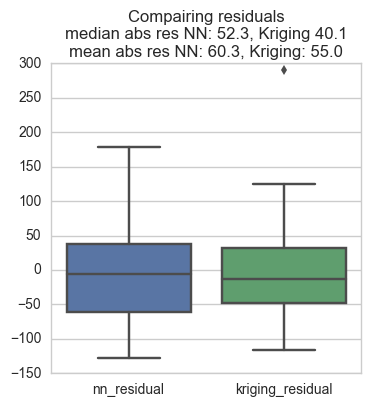

In [29]:
sb.set_style("whitegrid")
plt.figure(figsize=(4,4))
sb.boxplot(data = meuse_test[["nn_residual","kriging_residual"]], )
plt.title('Compairing residuals\nmedian abs res NN: {:.1f}, Kriging {:.1f}\nmean abs res NN: {:.1f}, Kriging: {:.1f}'\
          .format(np.median(np.abs(meuse_test['nn_residual'])), np.median(np.abs(meuse_test['kriging_residual'])),
                 np.mean(np.abs(meuse_test['nn_residual'])), np.mean(np.abs(meuse_test['kriging_residual']))))

## Sample a grid for a map

- Find the convex hull surrounding the measurements
- Sample a grid as found on http://portolan.leaffan.net/creating-sample-points-with-ogr-and-shapely-pt-2-regular-grid-sampling/

In [30]:
%run gridsampler.py

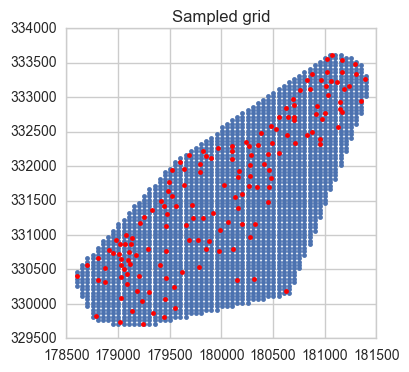

In [31]:
convex_hull = shapely.geometry.MultiPoint(list(meuse.geometry)).convex_hull.buffer(50)
sampler = RegularGridSampler(convex_hull, x_interval=50, y_interval=50)
sampler.perform_sampling()
grid_points = sampler.get_spatial_df()
plt.figure(figsize=(4,4))
plt.plot(grid_points['x'], grid_points['y'], '.')
plt.plot(meuse['x'], meuse['y'], 'r.')
plt.title('Sampled grid')

## Krige a value for each grid point

In [14]:
grid_points['prediction'] = model.execute(style = 'points', xpoints = grid_points['x'], 
                                          ypoints = grid_points['y'])[0].data

Executing Ordinary Kriging...



## Transform data for a map

- Transform to lat long projection
- From long to wide format
- Fill in missing values

In [16]:
grid_points_gpd = grid_points.set_geometry('geometry')
grid_points_gpd.crs = {'init':'epsg:28992'}
grid_points_gpd = grid_points_gpd.to_crs({'init': 'epsg:4326'})
grid_points_gpd['long'] = grid_points_gpd.geometry.apply(lambda x: x.x)
grid_points_gpd['lat'] = grid_points_gpd.geometry.apply(lambda x: x.y)

In [17]:
grid_points_pivot = grid_points_gpd.pivot(values = 'prediction', columns = 'x', index = 'y').fillna(0)
grid_points_pivot = grid_points_pivot.loc[:,grid_points_pivot.columns.sort_values(ascending = True)]
grid_points_pivot = grid_points_pivot.loc[grid_points_pivot.index.sort_values(ascending = True),:]

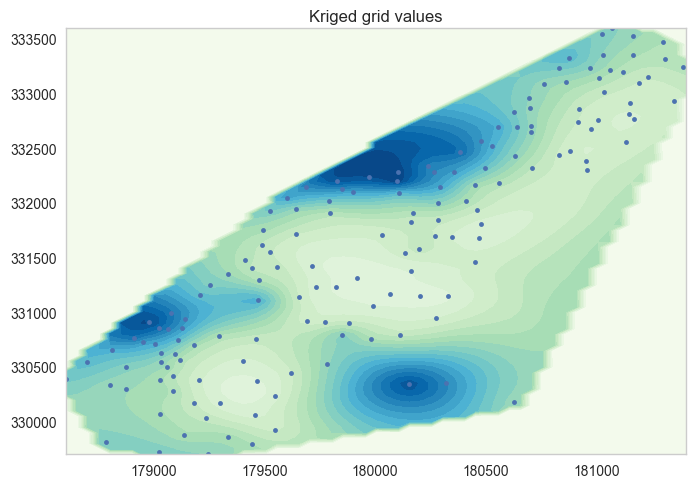

In [18]:
plt.contourf(np.unique(grid_points_pivot.columns.values), np.unique(grid_points_pivot.index.values), 
             grid_points_pivot.values/np.nanmax(grid_points_pivot.values),20,cmap='GnBu')
plt.plot(meuse['x'], meuse['y'], '.')
plt.title('Kriged grid values')

## Folium plot

In [19]:
def color_function(value):
    if (value == 0) | (value == np.nan) : return (0,0,0,0)
    else: 
        color = matplotlib.cm.YlOrRd(value) 
        return color

In [22]:
from folium import plugins

In [23]:
m = folium.Map([mean_lat, mean_long], zoom_start=13, tiles='Stamen Toner')
m.add_children(plugins.ImageOverlay(image = (grid_points_pivot.values/np.nanmax(grid_points_pivot.values)), 
                                           opacity=0.7,origin = 'lower',
                                           colormap = color_function,
                                   bounds = [[np.min(grid_points_gpd['lat']), np.min(grid_points_gpd['long'])],
                                            [np.max(grid_points_gpd['lat']), np.max(grid_points_gpd['long'])]]))
for row in meuse_lat_long.iterrows():
    folium.CircleMarker(location=[row[1]['lat'], row[1]['long']], radius=50,color=None,fill_opacity = 1,
                    fill_color=scale(row[1][feature_to_plot])).add_to(m)
m.add_children(scale)